<a href="https://colab.research.google.com/github/Amine8kh/AmineAIT/blob/main/SARIMA_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
import sys
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [218]:
data = pd.read_csv("/content/Truck_sales.csv")
data.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


In [219]:
  dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(data))

In [220]:
#Creating new columns with Month & date
import calendar
data['Month'] = dates.month
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x]) #spltting into english month names
data['Year'] = dates.year

In [221]:
#Dropping the original Month-Year column
data.drop(['Month-Year'], axis=1, inplace=True)
data.rename(columns={'Number_Trucks_Sold':'Truck-Sales'}, inplace=True) #renaming Number_Trucks_Sold column
data = data[['Month', 'Year', 'Truck-Sales']]

In [222]:
data.set_index(dates, inplace=True)
data.head()

,Month,Year,Truck-Sales
2003-01-01,Jan,2003,155
2003-02-01,Feb,2003,173
2003-03-01,Mar,2003,204
2003-04-01,Apr,2003,219
2003-05-01,May,2003,223


Text(0, 0.5, 'Truck Sales')

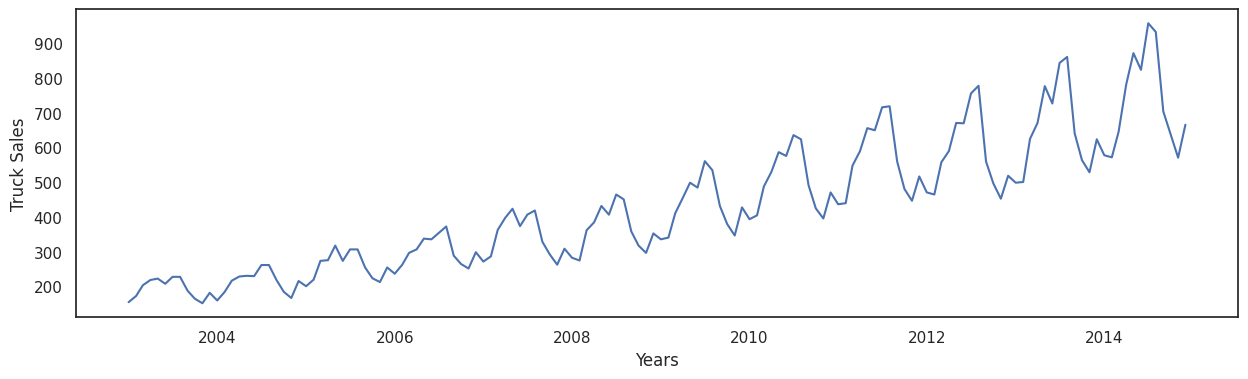

In [223]:
y = data['Truck-Sales']
sns.set(style="white", rc={'figure.figsize': (15, 4)})
plt.figure(figsize=(15, 4))
plt.plot(y)
plt.xlabel('Years')
plt.ylabel('Truck Sales')

In [185]:
from statsmodels.tsa.stattools import adfuller
res=adfuller(y)
print('statistique de test : ' , res[0])
print('valeur critique de 1% : ' , res[4]["1%"])
print('valeur critique de 5% :' , res[4]['5%'])
print('valeur critique de 10% : ' , res[4]['10%'])
print("P_value : ", res[1])
if res[1] <0.05 :
  print(' Rejeter l hypothese null , la serie est probablement stationnaire')
else:
  print('Acceptation du hypothese null , la serie n est pas stationnaire ')

statistique de test :  1.1158932574252673
valeur critique de 1% :  -3.482087964046026
valeur critique de 5% : -2.8842185101614626
valeur critique de 10% :  -2.578864381347275
P_value :  0.9953500083802601
Acceptation du hypothese null , la serie n est pas stationnaire 


In [186]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

transformations = ['diff', 'log', 'sqrt' , 'diff_log']
para_grid = {'diff': range(1, 5), 'log': [1], 'sqrt': [1] , 'diff_log':range(1,5)}
best_trans = None
best_order = None
best_adfuller = np.inf
p_value = None

for trans in transformations:
    for order in para_grid[trans]:
        if trans == 'diff':
            y_trans = y.diff(order).dropna()
        elif trans == 'log':
            y_trans = np.log(y)
        elif trans == 'sqrt':
            y_trans = np.sqrt(y)
        elif trans == 'tanh':
            y_trans = np.tanh(y)
        elif trans=='diff_log':
          y_tran=np.log(y).diff(order)

        # Print intermediate results
        #print(f'Transformation: {trans}, Order: {order}, Unique Values: {y_trans.unique()}')

        adf_stat, pvalue, usedlag, nobs, critical_values, icbest = adfuller(y_trans.values)

        if adf_stat < best_adfuller:
            best_adfuller = adf_stat
            best_trans = trans
            best_order = order
            p_value = pvalue

print('La meilleure transformation est : ', best_trans)
print('Le meilleur ordre est : ', best_order)
print('La meilleure statistique ADF est :', best_adfuller)
print('P-value est : ', p_value)


La meilleure transformation est :  diff
Le meilleur ordre est :  3
La meilleure statistique ADF est : -2.9380843975267004
P-value est :  0.04109516897222794


Text(0, 0.5, 'Differenced (Truck Sales)')

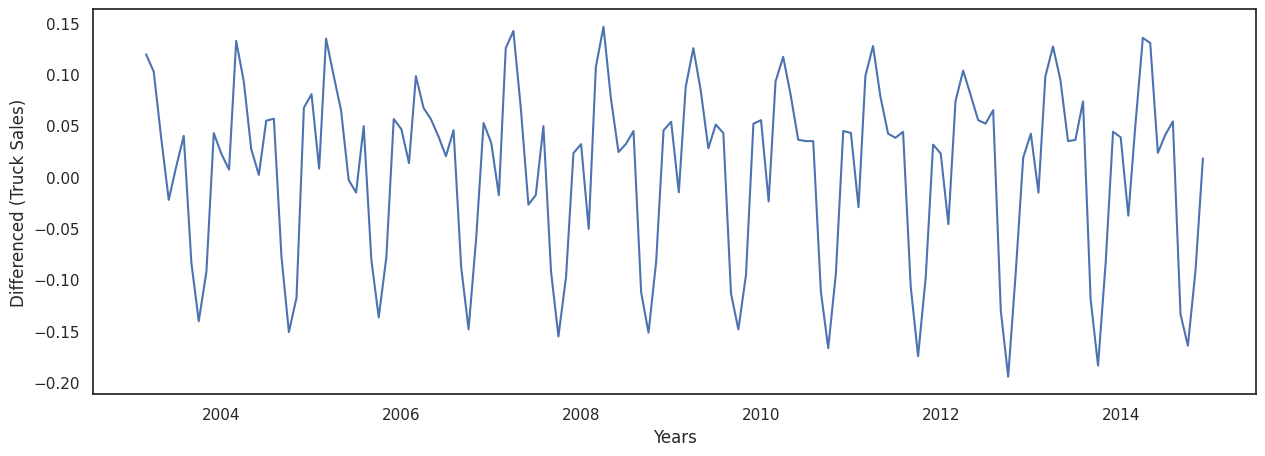

In [214]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(y).diff(periods=2))
plt.xlabel('Years')
plt.ylabel('Differenced (Truck Sales)')

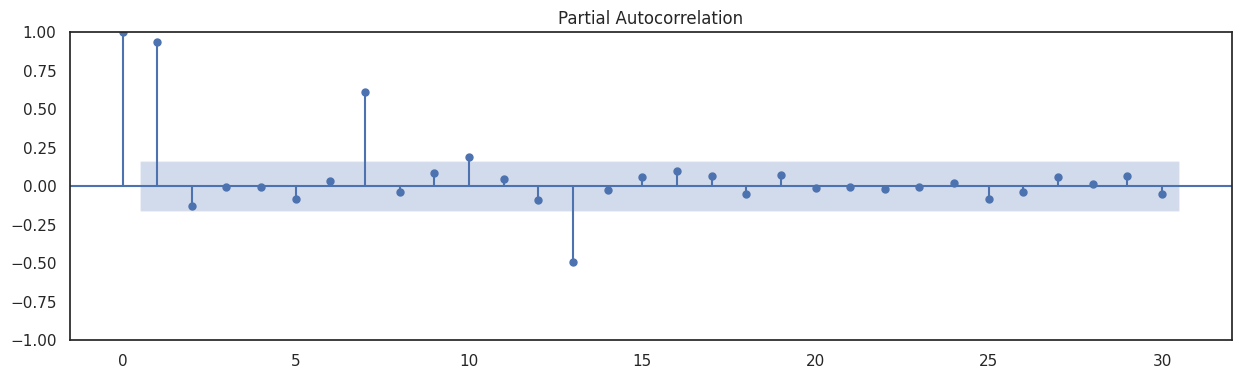

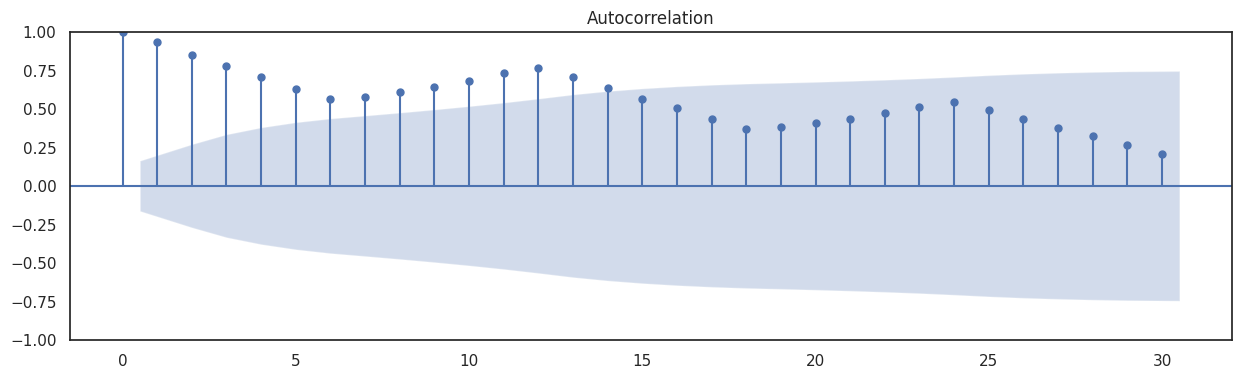

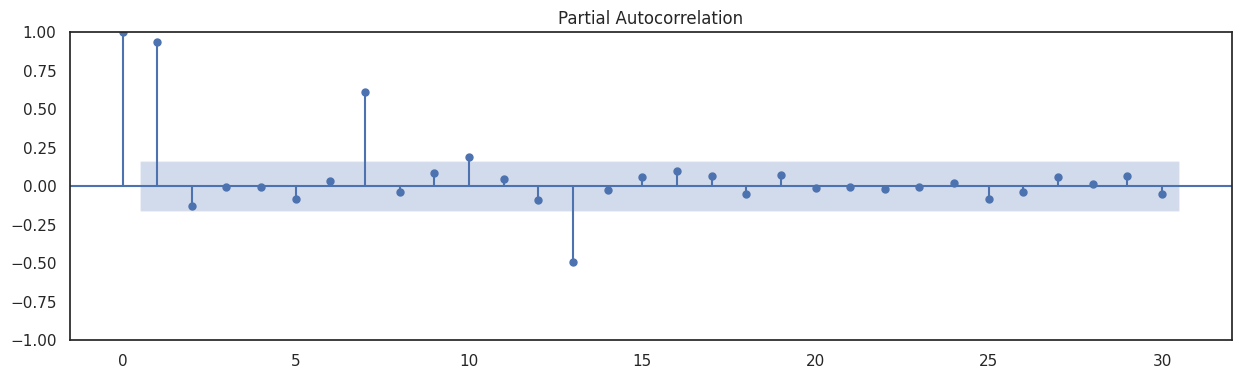

In [211]:
train_sales_ts_log = np.log10(y)
##SARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y, lags=30)
plot_pacf(y , lags=30)

In [189]:
d= range(0,2)
q = range(1, 4)
p= range(1,4)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [190]:
#Separate data into train and test
import calendar
data['date'] = data.index
train = data[data.index < '2013-01-01']
test = data[data.index >= '2013-01-01']

In [191]:
train['Truck-Sales'].diff(periods=3)

2003-01-01      NaN
2003-02-01      NaN
2003-03-01      NaN
2003-04-01     64.0
2003-05-01     50.0
              ...  
2012-08-01    107.0
2012-09-01   -110.0
2012-10-01   -259.0
2012-11-01   -325.0
2012-12-01    -41.0
Freq: MS, Name: Truck-Sales, Length: 120, dtype: float64

In [192]:
best_aic=np.inf
best_pqd=None
best_ses_pqd=None
temp_model=None

In [193]:
Sarima_aic=pd.DataFrame(columns=['para' , 'Seasen' , 'AIC'])
Sarima_aic

,para,Seasen,AIC


In [194]:
pdq = list(itertools.product(p, d, q))

In [195]:
train_sales_ts_log = np.log10(train['Truck-Sales'])
for para in pdq:
  for para_seasonal in seasonal_pdq:
    SARIMA_model=sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                           order=para,
                                           seasonal_order=para_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
result_SARIMA=SARIMA_model.fit(maxiter=1000)
print('SARIMA{}x{} - AIC:{}'.format(para, para_seasonal, result_SARIMA.aic))
Sarima_aic.loc[len(Sarima_aic)] = [para, para_seasonal, result_SARIMA.aic]


SARIMA(3, 1, 3)x(3, 1, 3, 12) - AIC:-385.11039167386036


In [196]:
Sarima_aic.sort_values(by=['AIC'],ascending=True).head()

,para,Seasen,AIC
0,"(3, 1, 3)","(3, 1, 3, 12)",-385.110392


In [197]:
best_model=sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                     order=(3,1,3),
                                     seasonal_order=(3,1,3,12),
                                     enforce_stationarity=True)
best_results=best_model.fit()

In [198]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                        Truck-Sales   No. Observations:                  120
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                 290.823
Date:                            Mon, 15 Jan 2024   AIC                           -555.645
Time:                                    17:11:32   BIC                           -520.898
Sample:                                01-01-2003   HQIC                          -541.559
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0906      0.250      0.362      0.717      -0.400       0.581
ar.L2         -0.4735      0.338   

In [199]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

In [200]:
pred99 = best_results.get_forecast(steps=len(test), alpha=0.1)
predicted_values = pred99.predicted_mean
confidence_interval = pred99.conf_int(alpha=0.1)

In [201]:
predicted_values

2013-01-01    2.692258
2013-02-01    2.686936
2013-03-01    2.774904
2013-04-01    2.809457
2013-05-01    2.857276
2013-06-01    2.852070
2013-07-01    2.904274
2013-08-01    2.903358
2013-09-01    2.784840
2013-10-01    2.725735
2013-11-01    2.688490
2013-12-01    2.757338
2014-01-01    2.726343
2014-02-01    2.724620
2014-03-01    2.808982
2014-04-01    2.840987
2014-05-01    2.890313
2014-06-01    2.888410
2014-07-01    2.938311
2014-08-01    2.938738
2014-09-01    2.818185
2014-10-01    2.758167
2014-11-01    2.722348
2014-12-01    2.789480
Freq: MS, Name: predicted_mean, dtype: float64

In [202]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)


In [216]:
testCopy.head()

,Month,Year,Truck-Sales,date,sales_ts_forecasted
2013-01-01,Jan,2013,499,2013-01-01,492.332444
2013-02-01,Feb,2013,501,2013-02-01,486.335409
2013-03-01,Mar,2013,625,2013-03-01,595.530474
2013-04-01,Apr,2013,671,2013-04-01,644.846865
2013-05-01,May,2013,777,2013-05-01,719.906920


In [204]:
# Compute the root mean square error
mse = ((testCopy['Truck-Sales'] - testCopy['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))


The Root Mean Squared Error of our forecasts is 51.422


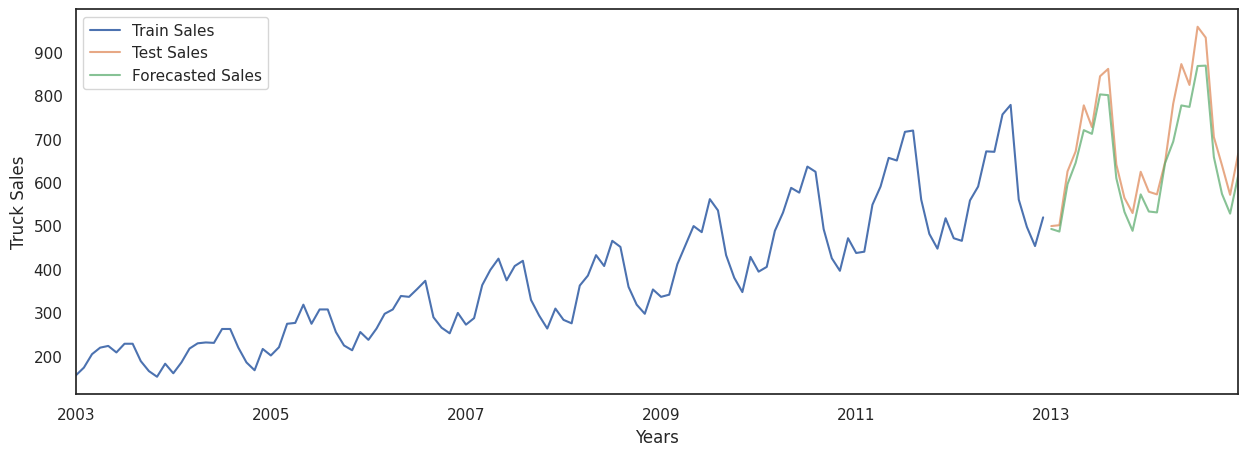

In [205]:
axis = train['Truck-Sales'].plot(label='Train Sales', figsize=(15, 5))
testCopy['Truck-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()
plt.close()


In [206]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 60
pred_uc_99 = best_results.get_forecast(steps=60, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=60, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()



In [207]:
n_steps = 60
idx = pd.date_range(start='2015-01-01',end='2019-12-31',freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]),
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]),
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()


,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2015-01-01,492.332444,459.144962,527.918751,459.144962,527.918751
2015-02-01,486.335409,448.381179,527.502359,448.381179,527.502359
2015-03-01,595.530474,540.926756,655.646150,540.926756,655.646150
2015-04-01,644.846865,582.177861,714.261925,582.177861,714.261925
2015-05-01,719.906920,647.043625,800.975318,647.043625,800.975318


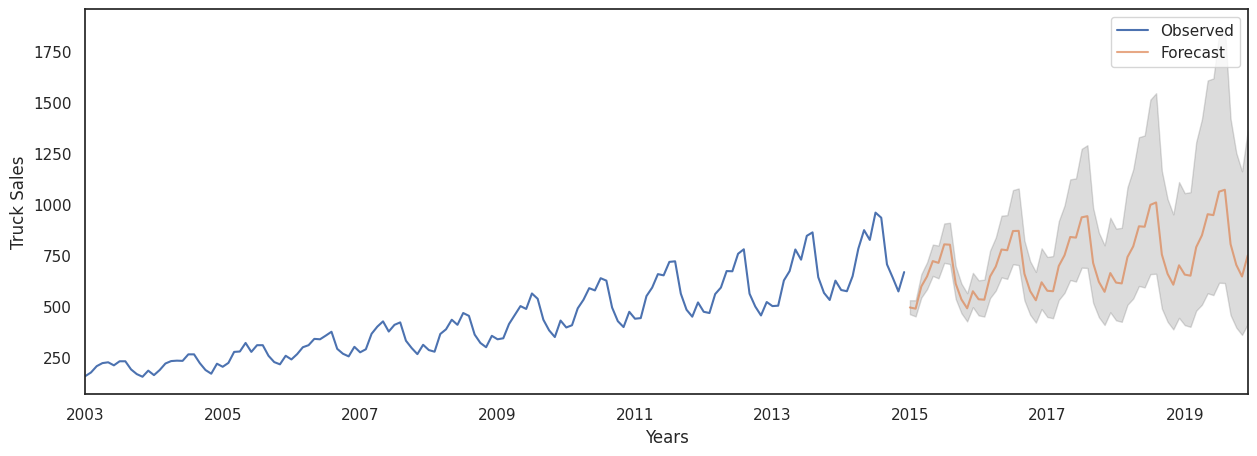

In [208]:
# plot the forecast along with the confidence band

axis = y.plot(label='Observed', figsize=(15, 5))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()


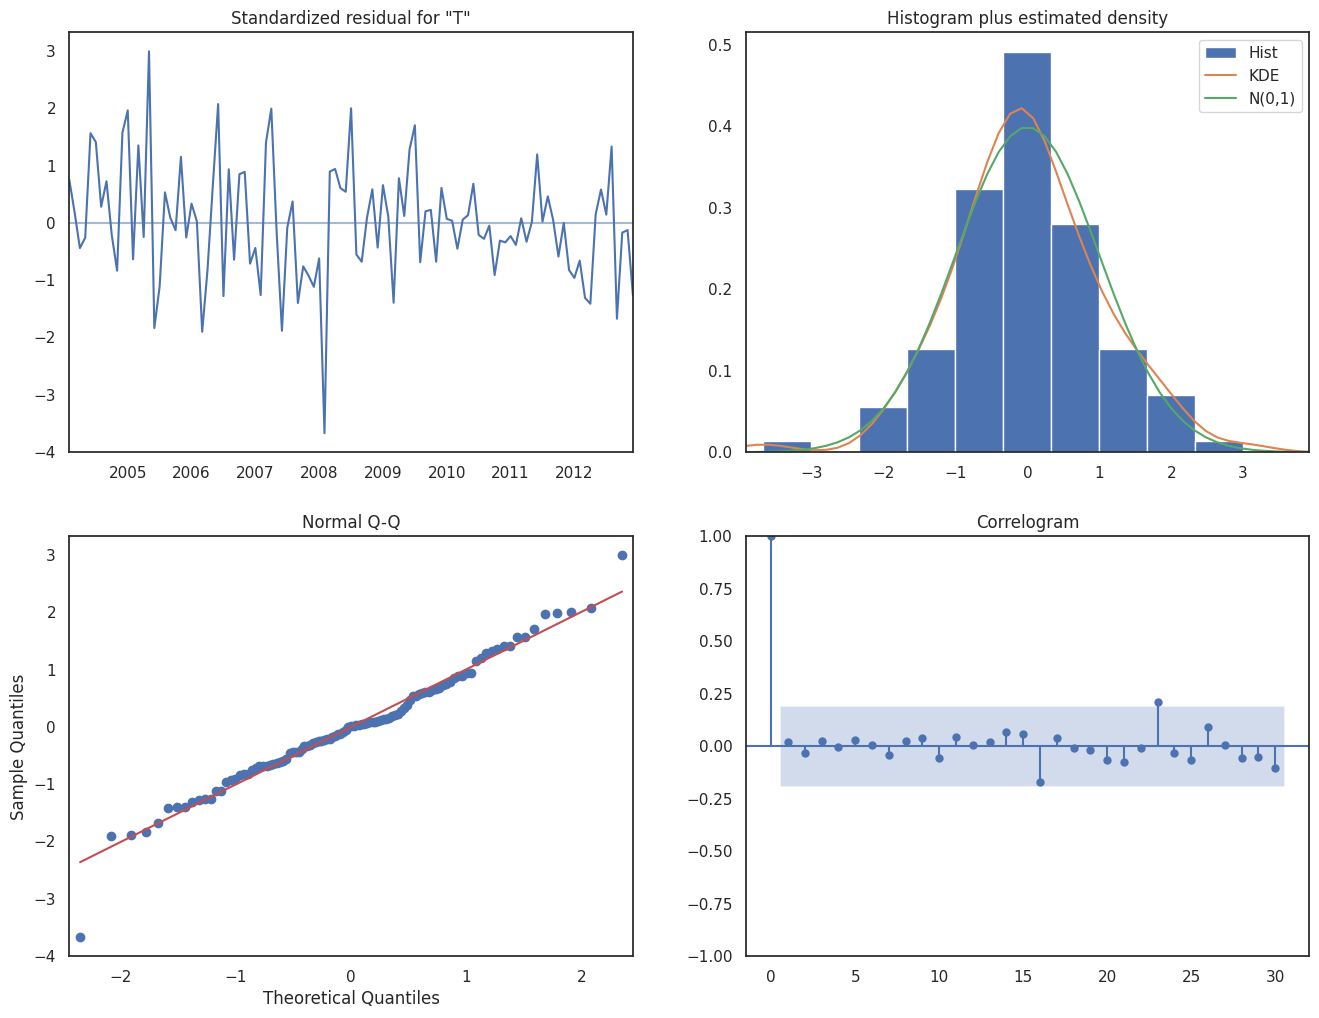

In [209]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()